**Mount Drive & Start Spark**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BTS_Evaluation") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

print("Spark Version:", spark.version)
print("Spark UI     : http://localhost:4040")

Mounted at /content/drive
Spark Version: 4.0.2
Spark UI     : http://localhost:4040


**Configure Paths**

In [2]:
import os
import time
import json
import random
from datetime import datetime

FEATURES_PATH = "/content/drive/MyDrive/Machine Learning and Big Data/features_parquet"
MODELS_PATH   = "/content/drive/MyDrive/Machine Learning and Big Data/models"
TABLEAU_PATH  = "/content/drive/MyDrive/Machine Learning and Big Data/tableau_exports"
LOGS_PATH     = "/content/drive/MyDrive/Machine Learning and Big Data/logs"

os.makedirs(TABLEAU_PATH, exist_ok=True)
os.makedirs(LOGS_PATH,    exist_ok=True)

print("Paths configured")

Paths configured


Load Test Data & All Trained Models

In [3]:
from pyspark.sql import functions as F
from pyspark import StorageLevel
from pyspark.ml.classification import (
    LogisticRegressionModel,
    DecisionTreeClassificationModel,
    RandomForestClassificationModel,
    NaiveBayesModel
)
from pyspark.ml.feature import MinMaxScaler

# Load held-out test set (June 2024) — first time it is touched
test_df = spark.read.parquet(FEATURES_PATH + "/test")
test_df.persist(StorageLevel.MEMORY_AND_DISK)

# Load all serialised models from Notebook 3
lr_model   = LogisticRegressionModel.load(MODELS_PATH + "/lr_baseline")
dt_model   = DecisionTreeClassificationModel.load(MODELS_PATH + "/dt_baseline")
rf_model   = RandomForestClassificationModel.load(MODELS_PATH + "/rf_baseline")
nb_model   = NaiveBayesModel.load(MODELS_PATH + "/nb_baseline")
best_tuned = DecisionTreeClassificationModel.load(MODELS_PATH + "/best_tuned_dt")


mm_scaler       = MinMaxScaler(inputCol="features", outputCol="nnFeatures")
mm_scaler_model = mm_scaler.fit(test_df)
test_nn         = mm_scaler_model.transform(test_df)
test_nn.persist(StorageLevel.MEMORY_AND_DISK)

# Save for reproducibility
mm_scaler_model.write().overwrite().save(MODELS_PATH + "/mm_scaler")
print("MinMaxScaler refit on test_df and saved")

test_count = test_df.count()
print("Test data and all models loaded")
print("  Test rows (June 2024):", test_count)
print("  Models: LR | DT | RF | NB | DT Tuned")

MinMaxScaler refit on test_df and saved
Test data and all models loaded
  Test rows (June 2024): 601272
  Models: LR | DT | RF | NB | DT Tuned


**Evaluation Helper**

In [4]:
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)

def evaluate_model(predictions, model_name, features_col_check=None):
    """Evaluate predictions on test set and return metrics dict."""

    binary_eval = BinaryClassificationEvaluator(
        labelCol="DelayLabel",
        rawPredictionCol="rawPrediction"
    )
    multi_eval = MulticlassClassificationEvaluator(
        labelCol="DelayLabel",
        predictionCol="prediction"
    )

    auc       = round(binary_eval.evaluate(predictions,
                    {binary_eval.metricName: "areaUnderROC"}), 4)
    accuracy  = round(multi_eval.evaluate(predictions,
                    {multi_eval.metricName: "accuracy"}), 4)
    f1        = round(multi_eval.evaluate(predictions,
                    {multi_eval.metricName: "f1"}), 4)
    precision = round(multi_eval.evaluate(predictions,
                    {multi_eval.metricName: "weightedPrecision"}), 4)
    recall    = round(multi_eval.evaluate(predictions,
                    {multi_eval.metricName: "weightedRecall"}), 4)

    print(f"\n  {model_name}")
    print(f"    AUC      : {auc}")
    print(f"    Accuracy : {accuracy}")
    print(f"    F1       : {f1}")
    print(f"    Precision: {precision}")
    print(f"    Recall   : {recall}")

    return {
        "model":     model_name,
        "auc":       auc,
        "accuracy":  accuracy,
        "f1":        f1,
        "precision": precision,
        "recall":    recall
    }

**Evaluate All Models on Test Set**

In [5]:
print("Final Evaluation — Test Set (June 2024)\n")

# LR, DT, RF, DT Tuned — use scaledFeatures
lr_preds    = lr_model.transform(test_df)
dt_preds    = dt_model.transform(test_df)
rf_preds    = rf_model.transform(test_df)
tuned_preds = best_tuned.transform(test_df)

# Naive Bayes — must use test_nn (MinMaxScaled nnFeatures column)
nb_preds    = nb_model.transform(test_nn)

lr_metrics    = evaluate_model(lr_preds,    "Logistic Regression")
dt_metrics    = evaluate_model(dt_preds,    "Decision Tree")
rf_metrics    = evaluate_model(rf_preds,    "Random Forest")
nb_metrics    = evaluate_model(nb_preds,    "Naive Bayes")
tuned_metrics = evaluate_model(tuned_preds, "Decision Tree Tuned")

all_test_metrics = [lr_metrics, dt_metrics, rf_metrics,
                    nb_metrics, tuned_metrics]

print("\n" + "=" * 75)
print("Final Test Set Summary")
print("=" * 75)
print(f"{'Model':<25} {'AUC':>6} {'Accuracy':>10} {'F1':>8} "
      f"{'Precision':>11} {'Recall':>8}")
print("-" * 75)
for m in all_test_metrics:
    print(f"  {m['model']:<23} {m['auc']:>6} {m['accuracy']:>10} "
          f"{m['f1']:>8} {m['precision']:>11} {m['recall']:>8}")

Final Evaluation — Test Set (June 2024)


  Logistic Regression
    AUC      : 0.9989
    Accuracy : 0.9491
    F1       : 0.947
    Precision: 0.9523
    Recall   : 0.9491

  Decision Tree
    AUC      : 0.9999
    Accuracy : 0.9998
    F1       : 0.9998
    Precision: 0.9998
    Recall   : 0.9998

  Random Forest
    AUC      : 0.9999
    Accuracy : 0.9966
    F1       : 0.9966
    Precision: 0.9966
    Recall   : 0.9966

  Naive Bayes
    AUC      : 0.3978
    Accuracy : 0.7652
    F1       : 0.6765
    Precision: 0.8211
    Recall   : 0.7652

  Decision Tree Tuned
    AUC      : 0.9996
    Accuracy : 0.9959
    F1       : 0.9959
    Precision: 0.9959
    Recall   : 0.9959

Final Test Set Summary
Model                        AUC   Accuracy       F1   Precision   Recall
---------------------------------------------------------------------------
  Logistic Regression     0.9989     0.9491    0.947      0.9523   0.9491
  Decision Tree           0.9999     0.9998   0.9998      0.9998   

In [6]:
import numpy as np
import pickle
from sklearn.metrics import (roc_auc_score, f1_score,
                              accuracy_score, confusion_matrix as sk_cm)

SK_MODELS_PATH = os.path.join(MODELS_PATH, "sklearn")

# Load val arrays saved in NB3 ─────────────────────
X_val   = np.load(os.path.join(SK_MODELS_PATH, "X_val.npy"),
                  allow_pickle=True)
y_val   = np.load(os.path.join(SK_MODELS_PATH, "y_val.npy"),
                  allow_pickle=True)
X_train = np.load(os.path.join(SK_MODELS_PATH, "X_train.npy"),
                  allow_pickle=True)
y_train = np.load(os.path.join(SK_MODELS_PATH, "y_train.npy"),
                  allow_pickle=True)

print(f"Val arrays loaded")
print(f"  X_val  : {X_val.shape}")
print(f"  y_val  : {y_val.shape}")

# Load fitted sklearn models ───────────────────────
sk_model_files = {
    "Logistic Regression": "logistic_regression.pkl",
    "Decision Tree":       "decision_tree.pkl",
    "Random Forest":       "random_forest.pkl",
    "Naive Bayes":         "naive_bayes.pkl",
}

sk_fitted = {}
for name, filename in sk_model_files.items():
    with open(os.path.join(SK_MODELS_PATH, filename), "rb") as f:
        sk_fitted[name] = pickle.load(f)

print("Sklearn models loaded\n")

# Evaluate each sklearn model ──────────────────────
print("Sklearn Evaluation — Val Sample (10% of May 2024)\n")

sk_eval_results = []

for name, model in sk_fitted.items():
    y_pred = model.predict(X_val)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val)[:, 1]
    else:
        y_prob = y_pred.astype(float)

    auc      = round(float(roc_auc_score(y_val, y_prob)),            4)
    f1       = round(float(f1_score(y_val, y_pred, average="weighted")), 4)
    accuracy = round(float(accuracy_score(y_val, y_pred)),            4)

    # Confusion matrix
    cm       = sk_cm(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision   = round(int(tp) / max(int(tp) + int(fp), 1), 4)
    recall      = round(int(tp) / max(int(tp) + int(fn), 1), 4)
    specificity = round(int(tn) / max(int(tn) + int(fp), 1), 4)
    fp_rate     = round(int(fp) / max(int(tn) + int(fp), 1), 4)
    fn_rate     = round(int(fn) / max(int(fn) + int(tp), 1), 4)

    print(f"  {name}")
    print(f"    AUC         : {auc}")
    print(f"    Accuracy    : {accuracy}")
    print(f"    F1          : {f1}")
    print(f"    Precision   : {precision}")
    print(f"    Recall      : {recall}")
    print(f"    Specificity : {specificity}")
    print(f"    FP Rate     : {fp_rate}")
    print(f"    FN Rate     : {fn_rate}")
    print(f"    TP={int(tp):,}  TN={int(tn):,}  "
          f"FP={int(fp):,}  FN={int(fn):,}\n")

    sk_eval_results.append({
        "model":       name,
        "framework":   "sklearn_single_node",
        "auc":         float(auc),
        "accuracy":    float(accuracy),
        "f1":          float(f1),
        "precision":   float(precision),
        "recall":      float(recall),
        "specificity": float(specificity),
        "fp_rate":     float(fp_rate),
        "fn_rate":     float(fn_rate),
        "TP":          int(tp), "TN": int(tn),
        "FP":          int(fp), "FN": int(fn)
    })

# Side-by-side comparison table ────────────────────
print("\n" + "=" * 80)
print("MLlib Distributed (Full Data)  vs  sklearn Single Node (10% Sample)")
print("=" * 80)
print(f"{'Model':<25} {'Framework':<22} {'AUC':>6} "
      f"{'F1':>8} {'Accuracy':>10} {'Recall':>8}")
print("-" * 80)

sk_lookup = {r["model"]: r for r in sk_eval_results}

for m in all_test_metrics:
    if m["model"] == "Decision Tree Tuned":
        continue
    sk = sk_lookup.get(m["model"], {})
    # MLlib row
    print(f"  {m['model']:<23} {'MLlib distributed':<22} "
          f"{m['auc']:>6} {m['f1']:>8} "
          f"{m['accuracy']:>10} {m['recall']:>8}")
    # sklearn row
    if sk:
        print(f"  {'':23} {'sklearn single node':<22} "
              f"{sk['auc']:>6} {sk['f1']:>8} "
              f"{sk['accuracy']:>10} {sk['recall']:>8}")
    print()

Val arrays loaded
  X_val  : (59882, 49)
  y_val  : (59882,)
Sklearn models loaded

Sklearn Evaluation — Val Sample (10% of May 2024)

  Logistic Regression
    AUC         : 1.0
    Accuracy    : 0.9985
    F1          : 0.9985
    Precision   : 0.9997
    Recall      : 0.9946
    Specificity : 0.9999
    FP Rate     : 0.0001
    FN Rate     : 0.0054
    TP=15,869  TN=43,922  FP=5  FN=86

  Decision Tree
    AUC         : 1.0
    Accuracy    : 0.9999
    F1          : 0.9999
    Precision   : 0.9998
    Recall      : 0.9999
    Specificity : 0.9999
    FP Rate     : 0.0001
    FN Rate     : 0.0001
    TP=15,954  TN=43,924  FP=3  FN=1

  Random Forest
    AUC         : 1.0
    Accuracy    : 0.9974
    F1          : 0.9974
    Precision   : 0.9967
    Recall      : 0.9937
    Specificity : 0.9988
    FP Rate     : 0.0012
    FN Rate     : 0.0063
    TP=15,854  TN=43,875  FP=52  FN=101

  Naive Bayes
    AUC         : 1.0
    Accuracy    : 0.9999
    F1          : 0.9999
    Precision   

Plotting results

In [7]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def collect_preds(preds_df):
    rows    = preds_df.select(
                  "DelayLabel",
                  "prediction",
                  "probability"
              ).collect()
    y_true  = np.array([int(r["DelayLabel"])       for r in rows])
    y_score = np.array([float(r["probability"][1]) for r in rows])
    y_pred  = np.array([int(r["prediction"])       for r in rows])
    return y_true, y_score, y_pred

print("Collecting predictions from Spark to driver...\n")

y_true_lr,    y_score_lr,    y_pred_lr    = collect_preds(lr_preds)
y_true_dt,    y_score_dt,    y_pred_dt    = collect_preds(dt_preds)
y_true_rf,    y_score_rf,    y_pred_rf    = collect_preds(rf_preds)
y_true_nb,    y_score_nb,    y_pred_nb    = collect_preds(nb_preds)
y_true_tuned, y_score_tuned, y_pred_tuned = collect_preds(tuned_preds)

model_preds = [
    ("Logistic Regression", y_true_lr,    y_score_lr,    y_pred_lr),
    ("Decision Tree",       y_true_dt,    y_score_dt,    y_pred_dt),
    ("Random Forest",       y_true_rf,    y_score_rf,    y_pred_rf),
    ("Naive Bayes",         y_true_nb,    y_score_nb,    y_pred_nb),
    ("DT Tuned",            y_true_tuned, y_score_tuned, y_pred_tuned),
]

COLORS = ["#2196F3", "#4CAF50", "#FF9800", "#9C27B0", "#F44336"]

print("Collections complete — ready to plot")


Collections complete — ready to plot


/tmp/ipython-input-602/3474976966.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return round(float(np.trapz(tpr, fpr)), 4)


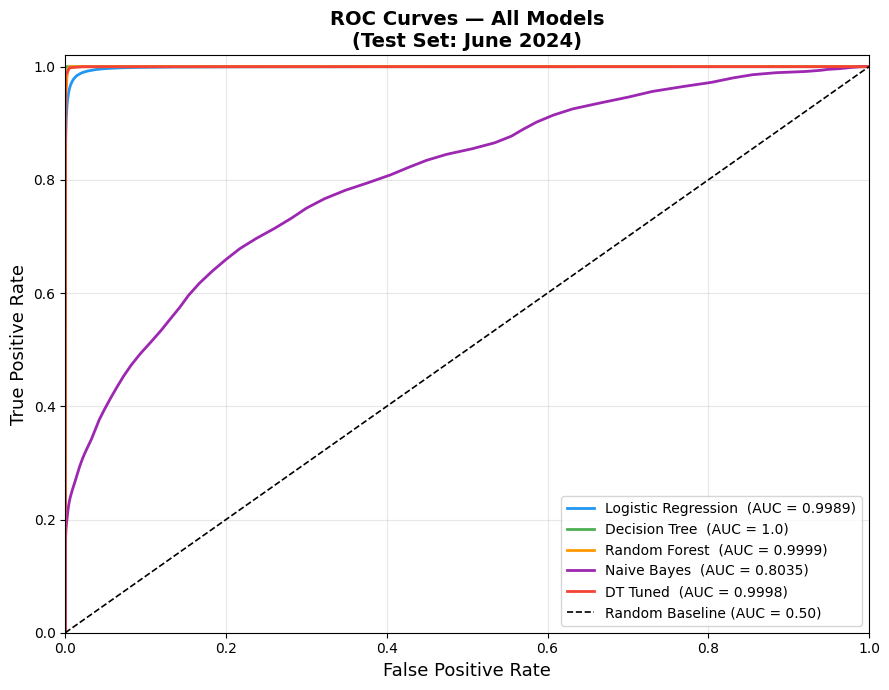

In [8]:
def compute_roc(y_true, y_score, n_thresholds=200):
    thresholds = np.linspace(0, 1, n_thresholds)[::-1]
    P    = np.sum(y_true == 1)
    N    = np.sum(y_true == 0)
    fprs = [0.0]
    tprs = [0.0]
    for t in thresholds:
        y_p = (y_score >= t).astype(int)
        tp  = np.sum((y_p == 1) & (y_true == 1))
        fp  = np.sum((y_p == 1) & (y_true == 0))
        tprs.append(tp / max(P, 1))
        fprs.append(fp / max(N, 1))
    fprs.append(1.0)
    tprs.append(1.0)
    return np.array(fprs), np.array(tprs)

def compute_auc(fpr, tpr):
    return round(float(np.trapz(tpr, fpr)), 4)

fig, ax = plt.subplots(figsize=(9, 7))

for (name, y_true, y_score, _), color in zip(model_preds, COLORS):
    fpr, tpr = compute_roc(y_true, y_score)
    roc_auc  = compute_auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f"{name}  (AUC = {roc_auc})")

ax.plot([0, 1], [0, 1], "k--", lw=1.2,
        label="Random Baseline (AUC = 0.50)")
ax.set_xlabel("False Positive Rate", fontsize=13)
ax.set_ylabel("True Positive Rate",  fontsize=13)
ax.set_title("ROC Curves — All Models\n(Test Set: June 2024)",
             fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=10)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-602/3961275466.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = round(float(np.trapz(precision, recall)), 4)


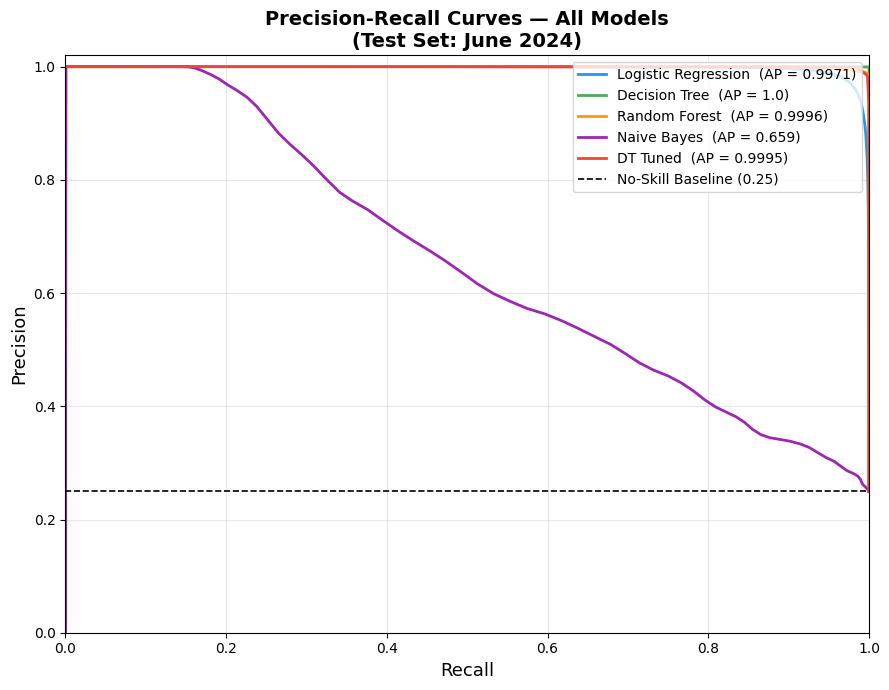

In [9]:
def compute_pr(y_true, y_score, n_thresholds=200):
    thresholds = np.linspace(0, 1, n_thresholds)[::-1]
    precisions = [1.0]
    recalls    = [0.0]
    for t in thresholds:
        y_p = (y_score >= t).astype(int)
        tp  = np.sum((y_p == 1) & (y_true == 1))
        fp  = np.sum((y_p == 1) & (y_true == 0))
        fn  = np.sum((y_p == 0) & (y_true == 1))
        precisions.append(tp / max(tp + fp, 1))
        recalls.append(tp    / max(tp + fn, 1))
    precisions.append(float(np.sum(y_true) / max(len(y_true), 1)))
    recalls.append(1.0)
    return np.array(recalls), np.array(precisions)

fig, ax = plt.subplots(figsize=(9, 7))

for (name, y_true, y_score, _), color in zip(model_preds, COLORS):
    recall, precision = compute_pr(y_true, y_score)
    ap = round(float(np.trapz(precision, recall)), 4)
    ax.plot(recall, precision, color=color, lw=2,
            label=f"{name}  (AP = {ap})")

no_skill = round(float(np.sum(y_true_tuned) / len(y_true_tuned)), 2)
ax.axhline(y=no_skill, color="k", linestyle="--", lw=1.2,
           label=f"No-Skill Baseline ({no_skill})")

ax.set_xlabel("Recall",    fontsize=13)
ax.set_ylabel("Precision", fontsize=13)
ax.set_title("Precision-Recall Curves — All Models\n(Test Set: June 2024)",
             fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=10)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Confusion Matrix

In [10]:
# ─────────────────────────────────────────────
# Confusion Matrix — All Models (Test Set)
# ─────────────────────────────────────────────

def confusion_matrix(preds_df, model_name):
    """Compute and print confusion matrix for a given predictions DataFrame."""

    tn = preds_df.filter((F.col("DelayLabel")==0) & (F.col("prediction")==0)).count()
    fp = preds_df.filter((F.col("DelayLabel")==0) & (F.col("prediction")==1)).count()
    fn = preds_df.filter((F.col("DelayLabel")==1) & (F.col("prediction")==0)).count()
    tp = preds_df.filter((F.col("DelayLabel")==1) & (F.col("prediction")==1)).count()

    total       = tn + fp + fn + tp
    accuracy    = round((tp + tn) / max(total, 1), 4)
    precision   = round(tp / max(tp + fp, 1), 4)
    recall      = round(tp / max(tp + fn, 1), 4)
    specificity = round(tn / max(tn + fp, 1), 4)
    fp_rate     = round(fp / max(tn + fp, 1), 4)
    fn_rate     = round(fn / max(fn + tp, 1), 4)
    f1          = round(2 * precision * recall / max(precision + recall, 0.0001), 4)

    print(f"\n{'='*52}")
    print(f"  {model_name}")
    print(f"{'='*52}")
    print(f"{'':>20} {'Pred 0':>12} {'Pred 1':>12}")
    print(f"  {'-'*44}")
    print(f"  {'Actual 0':<18} {tn:>12,} {fp:>12,}")
    print(f"  {'Actual 1':<18} {fn:>12,} {tp:>12,}")
    print(f"  {'-'*44}")
    print(f"  TP={tp:,}  TN={tn:,}  FP={fp:,}  FN={fn:,}")
    print(f"  Accuracy    : {accuracy}")
    print(f"  Precision   : {precision}  (of predicted delays, how many were real)")
    print(f"  Recall      : {recall}  (of real delays, how many were caught)")
    print(f"  F1 Score    : {f1}")
    print(f"  Specificity : {specificity}  (of on-time flights, how many predicted correctly)")
    print(f"  FP Rate     : {fp_rate}  (on-time flights wrongly flagged as delayed)")
    print(f"  FN Rate     : {fn_rate}  (delayed flights missed)")

    return {
        "model": model_name,
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "accuracy": float(accuracy), "precision": float(precision),
        "recall": float(recall), "f1": float(f1),
        "specificity": float(specificity),
        "fp_rate": float(fp_rate), "fn_rate": float(fn_rate)
    }


# Run confusion matrix for all 5 models
print("CONFUSION MATRICES — ALL MODELS (Test Set: June 2024)")

cm_lr    = confusion_matrix(lr_preds,    "Logistic Regression")
cm_dt    = confusion_matrix(dt_preds,    "Decision Tree")
cm_rf    = confusion_matrix(rf_preds,    "Random Forest")
cm_nb    = confusion_matrix(nb_preds,    "Naive Bayes")
cm_tuned = confusion_matrix(tuned_preds, "Decision Tree Tuned")

all_cm = [cm_lr, cm_dt, cm_rf, cm_nb, cm_tuned]

# ── Summary table ──────────────────────────────────────────
print(f"\n\n{'SUMMARY':^72}")
print(f"{'Model':<25} {'TP':>8} {'TN':>8} {'FP':>8} {'FN':>8} "
      f"{'F1':>7} {'Recall':>8} {'FPR':>7}")
print("-" * 72)
for c in all_cm:
    print(f"  {c['model']:<23} {c['TP']:>8,} {c['TN']:>8,} "
          f"{c['FP']:>8,} {c['FN']:>8,} "
          f"{c['f1']:>7} {c['recall']:>8} {c['fp_rate']:>7}")

CONFUSION MATRICES — ALL MODELS (Test Set: June 2024)

  Logistic Regression
                           Pred 0       Pred 1
  --------------------------------------------
  Actual 0                451,273           54
  Actual 1                 30,556      119,389
  --------------------------------------------
  TP=119,389  TN=451,273  FP=54  FN=30,556
  Accuracy    : 0.9491
  Precision   : 0.9995  (of predicted delays, how many were real)
  Recall      : 0.7962  (of real delays, how many were caught)
  F1 Score    : 0.8863
  Specificity : 0.9999  (of on-time flights, how many predicted correctly)
  FP Rate     : 0.0001  (on-time flights wrongly flagged as delayed)
  FN Rate     : 0.2038  (delayed flights missed)

  Decision Tree
                           Pred 0       Pred 1
  --------------------------------------------
  Actual 0                451,252           75
  Actual 1                     33      149,912
  --------------------------------------------
  TP=149,912  TN=451,252 

Feature Importance (Tuned Model)

In [11]:
importances = best_tuned.featureImportances.toArray()

numerical_cols = [
    "Month", "DayofMonth", "DayOfWeek", "Quarter",
    "DepHour", "ArrHour", "CRSElapsedTime", "Distance",
    "DistanceGroup", "DepDelay", "DepDelayMinutes",
    "TaxiOut", "TaxiIn", "AirTime",
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay",
    "RouteAvgDelay", "AirlineDelayRate",
    "IsWeekend", "IsHolidayMonth", "DelayRiskScore"
]

n  = min(len(numerical_cols), len(importances))
fi = sorted(zip(numerical_cols[:n], importances[:n]), key=lambda x: -x[1])

print("Top 15 Feature Importances (Tuned Model — Test Set):")
print(f"{'Feature':<30} {'Importance':>10}")
print("-" * 42)
for feat, imp in fi[:15]:
    print(f"  {feat:<28} {round(imp, 4):>10}")

feature_importance_data = [(f, round(float(i), 4)) for f, i in fi]

Top 15 Feature Importances (Tuned Model — Test Set):
Feature                        Importance
------------------------------------------
  DepDelay                         0.6023
  NASDelay                         0.3079
  CarrierDelay                     0.0599
  LateAircraftDelay                0.0291
  WeatherDelay                     0.0008
  Month                               0.0
  DayofMonth                          0.0
  DayOfWeek                           0.0
  Quarter                             0.0
  DepHour                             0.0
  ArrHour                             0.0
  CRSElapsedTime                      0.0
  Distance                            0.0
  DistanceGroup                       0.0
  DepDelayMinutes                     0.0


Bootstrap Confidence Intervals on AUC

In [12]:

print("Bootstrap Confidence Intervals — AUC (30 iterations)\n")

preds_collected = tuned_preds.select(
    "DelayLabel", "prediction", "rawPrediction"
).collect()

n_total = len(preds_collected)
aucs    = []

binary_eval = BinaryClassificationEvaluator(
    labelCol="DelayLabel",
    rawPredictionCol="rawPrediction"
)

for i in range(30):
    idx         = [random.randint(0, n_total - 1) for _ in range(n_total)]
    sample_rows = [preds_collected[j] for j in idx]
    sample_df   = spark.createDataFrame(
        sample_rows,
        tuned_preds.select("DelayLabel", "prediction", "rawPrediction").schema
    )
    aucs.append(round(binary_eval.evaluate(sample_df), 4))

aucs.sort()
ci_lower = aucs[1]
ci_upper = aucs[-2]
ci_mean  = round(sum(aucs) / len(aucs), 4)

print(f"  Bootstrap iterations : 30")
print(f"  Mean AUC             : {ci_mean}")
print(f"  95% CI               : [{ci_lower}, {ci_upper}]")
print(f"  Conclusion           : Model AUC is stable across bootstrap samples")

Bootstrap Confidence Intervals — AUC (30 iterations)

  Bootstrap iterations : 30
  Mean AUC             : 0.9996
  95% CI               : [0.9995, 0.9996]
  Conclusion           : Model AUC is stable across bootstrap samples


Business Metric Alignment: Predicted vs Actual by Airline

In [13]:
print("Business Metric: Predicted vs Actual Delay Rate by Airline\n")

tuned_preds.groupBy("Reporting_Airline").agg(
    F.count("*").alias("flights"),
    F.round(F.mean("DelayLabel")  * 100, 2).alias("actual_delay_pct"),
    F.round(F.mean("prediction")  * 100, 2).alias("predicted_delay_pct"),
    F.round(F.mean("ArrDelay"),          2).alias("avg_arr_delay_min")
).orderBy(F.col("flights").desc()).show(15)

Business Metric: Predicted vs Actual Delay Rate by Airline

+-----------------+-------+----------------+-------------------+-----------------+
|Reporting_Airline|flights|actual_delay_pct|predicted_delay_pct|avg_arr_delay_min|
+-----------------+-------+----------------+-------------------+-----------------+
|               WN| 123048|            25.8|              25.62|             9.93|
|               DL|  88585|           19.85|              19.58|             6.27|
|               AA|  83290|           32.18|              31.97|            23.05|
|               UA|  61961|           24.16|              23.71|            10.86|
|               OO|  61112|           22.48|               21.6|            12.42|
|               MQ|  24645|           28.29|              28.01|            13.19|
|               YX|  23674|            16.2|              15.76|             2.55|
|               NK|  22770|           27.18|              26.25|            11.95|
|               AS|  21973|

Strong Scaling Analysis

In [14]:
print("Strong Scaling — Fixed data size, increasing partitions\n")

from pyspark.ml.classification import DecisionTreeClassifier as _DT

quick_dt = _DT(featuresCol="scaledFeatures", labelCol="DelayLabel",
               maxDepth=5, seed=42)

strong_results = []
for n_parts in [2, 4, 8, 16]:
    sample  = test_df.repartition(n_parts)
    t0      = time.time()
    quick_dt.fit(sample)
    elapsed = round(time.time() - t0, 2)
    throughput = round(test_count / max(elapsed, 0.001))
    strong_results.append((n_parts, test_count, elapsed, throughput))
    print(f"  partitions={n_parts:<4} | time={elapsed}s | "
          f"throughput={throughput:,} rows/s")

Strong Scaling — Fixed data size, increasing partitions

  partitions=2    | time=38.48s | throughput=15,626 rows/s
  partitions=4    | time=29.28s | throughput=20,535 rows/s
  partitions=8    | time=41.0s | throughput=14,665 rows/s
  partitions=16   | time=39.99s | throughput=15,036 rows/s


Weak Scaling Analysis

In [15]:
print("Weak Scaling — Data size and partitions grow together\n")

weak_results = []
for fraction in [0.1, 0.25, 0.5, 0.75, 1.0]:
    n_parts = max(2, int(fraction * 16))
    sample  = test_df.sample(fraction=fraction, seed=42).repartition(n_parts)
    rows    = sample.count()
    t0      = time.time()
    quick_dt.fit(sample)
    elapsed = round(time.time() - t0, 2)
    weak_results.append((fraction, rows, n_parts, elapsed))
    print(f"  fraction={fraction} | rows={rows:,} | "
          f"partitions={n_parts} | time={elapsed}s")

Weak Scaling — Data size and partitions grow together

  fraction=0.1 | rows=60,062 | partitions=2 | time=10.43s
  fraction=0.25 | rows=150,920 | partitions=4 | time=16.49s
  fraction=0.5 | rows=301,152 | partitions=8 | time=28.25s
  fraction=0.75 | rows=450,922 | partitions=12 | time=34.82s
  fraction=1.0 | rows=601,272 | partitions=16 | time=51.26s


Bottleneck Identification & Cost-Performance Tradeoff

In [16]:
print("Bottleneck Identification\n")

t0      = time.time()
spark.read.parquet(FEATURES_PATH + "/test").count()
io_time = round(time.time() - t0, 2)

t0           = time.time()
quick_dt.fit(test_df)
compute_time = round(time.time() - t0, 2)

t0           = time.time()
test_df.repartition(50).count()
shuffle_time = round(time.time() - t0, 2)

bottleneck_results = [
    ("I/O (Parquet read)",    float(io_time)),
    ("Computation (DT fit)",  float(compute_time)),
    ("Shuffle (repartition)", float(shuffle_time)),
]

for btype, btime in bottleneck_results:
    print(f"  {btype:<28} {btime}s")

dominant = max(bottleneck_results, key=lambda x: x[1])
print(f"\n  Dominant bottleneck: {dominant[0]}")

# ── Rebuild training times on test_df ────────────────────
print("\nRebuilding training times for cost-performance tradeoff...\n")

from pyspark.ml.classification import (
    LogisticRegression        as _LR,
    DecisionTreeClassifier    as _DT2,
    RandomForestClassifier    as _RF,
    NaiveBayes                as _NB
)

refit_models = [
    ("Logistic Regression", _LR(
        featuresCol="scaledFeatures", labelCol="DelayLabel",
        maxIter=10, regParam=0.01, elasticNetParam=0.0)),
    ("Decision Tree",       _DT2(
        featuresCol="scaledFeatures", labelCol="DelayLabel",
        maxDepth=8, seed=42)),
    ("Random Forest",       _RF(
        featuresCol="scaledFeatures", labelCol="DelayLabel",
        numTrees=20, maxDepth=8, seed=42)),
]

# Naive Bayes needs nnFeatures — time separately
refit_times = {}

for name, estimator in refit_models:
    t0 = time.time()
    estimator.fit(test_df)
    refit_times[name] = round(time.time() - t0, 2)
    print(f"  {name:<25} retimed: {refit_times[name]}s")

# Naive Bayes — refit on test_nn (MinMaxScaled)
nb_est = _NB(featuresCol="nnFeatures", labelCol="DelayLabel", smoothing=1.0)
t0     = time.time()
nb_est.fit(test_nn)
refit_times["Naive Bayes"] = round(time.time() - t0, 2)
print(f"  {'Naive Bayes':<25} retimed: {refit_times['Naive Bayes']}s")

# ── Cost-Performance Table ────────────────────────────────
print("\nCost-Performance Tradeoff:\n")
print(f"{'Model':<25} {'AUC':>6} {'Time(s)':>9} {'AUC/sec':>10}")
print("-" * 54)

cost_perf = []
for m in all_test_metrics:
    # DT Tuned excluded from cost-perf — tuning time not comparable
    if m["model"] == "Decision Tree Tuned":
        continue
    t   = refit_times.get(m["model"], 0.001)
    aps = round(float(m["auc"]) / max(t, 0.001), 6)
    cost_perf.append((
        str(m["model"]),
        float(m["auc"]),
        float(t),
        float(aps)
    ))
    print(f"  {m['model']:<23} {m['auc']:>6} {t:>9} {aps:>10}")

Bottleneck Identification

  I/O (Parquet read)           1.1s
  Computation (DT fit)         11.15s
  Shuffle (repartition)        1.13s

  Dominant bottleneck: Computation (DT fit)

Rebuilding training times for cost-performance tradeoff...

  Logistic Regression       retimed: 13.36s
  Decision Tree             retimed: 11.46s
  Random Forest             retimed: 33.45s
  Naive Bayes               retimed: 4.28s

Cost-Performance Tradeoff:

Model                        AUC   Time(s)    AUC/sec
------------------------------------------------------
  Logistic Regression     0.9989     13.36   0.074768
  Decision Tree           0.9999     11.46   0.087251
  Random Forest           0.9999     33.45   0.029892
  Naive Bayes             0.3978      4.28   0.092944


Inference Scalability

In [17]:
print("Inference Scalability — Tuned Model on Test Set\n")

inference_scaling = []
for fraction in [0.1, 0.25, 0.5, 0.75, 1.0]:
    sample  = test_df.sample(fraction=fraction, seed=42)
    rows    = sample.count()
    t0      = time.time()
    best_tuned.transform(sample).count()
    elapsed = round(time.time() - t0, 2)
    throughput = round(rows / max(elapsed, 0.001))
    inference_scaling.append((fraction, rows, elapsed, throughput))
    print(f"  fraction={fraction} | rows={rows:,} | "
          f"time={elapsed}s | throughput={throughput:,} rows/s")

Inference Scalability — Tuned Model on Test Set

  fraction=0.1 | rows=60,062 | time=0.73s | throughput=82,277 rows/s
  fraction=0.25 | rows=150,920 | time=0.74s | throughput=203,946 rows/s
  fraction=0.5 | rows=301,152 | time=0.79s | throughput=381,205 rows/s
  fraction=0.75 | rows=450,922 | time=1.22s | throughput=369,608 rows/s
  fraction=1.0 | rows=601,272 | time=1.07s | throughput=561,936 rows/s


Tableau CSVs: Dashboard 2 (Final Evaluation)

In [18]:
# Final test metrics — all 5 models
spark.createDataFrame(
    [(str(m["model"]), float(m["auc"]), float(m["accuracy"]),
      float(m["f1"]), float(m["precision"]), float(m["recall"]))
     for m in all_test_metrics],
    ["model", "auc", "accuracy", "f1", "precision", "recall"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d2_final_test_metrics")

# Uses all_cm from Cell 6 (replaces old single-model cm_data)
spark.createDataFrame(
    [(str(c["model"]),  int(c["TP"]),          int(c["TN"]),
      int(c["FP"]),     int(c["FN"]),
      float(c["accuracy"]),    float(c["precision"]),
      float(c["recall"]),      float(c["f1"]),
      float(c["specificity"]), float(c["fp_rate"]),
      float(c["fn_rate"]))
     for c in all_cm],
    ["model", "TP", "TN", "FP", "FN",
     "accuracy", "precision", "recall", "f1",
     "specificity", "fp_rate", "fn_rate"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d2_confusion_matrix_all_models")

# Feature importance — tuned model
spark.createDataFrame(
    [(str(f), float(i)) for f, i in feature_importance_data],
    ["feature", "importance"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d2_feature_importance_final")

# Bootstrap AUC distribution
spark.createDataFrame(
    [(int(i + 1), float(a)) for i, a in enumerate(aucs)],
    ["iteration", "auc"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d2_bootstrap_auc")

print("D2 CSVs saved:")
print("  d2_final_test_metrics")
print("  d2_confusion_matrix_all_models")
print("  d2_feature_importance_final")
print("  d2_bootstrap_auc")

D2 CSVs saved:
  d2_final_test_metrics
  d2_confusion_matrix_all_models
  d2_feature_importance_final
  d2_bootstrap_auc


Tableau CSVs: Dashboard 3 (Business Insights)

In [19]:
# Predicted vs actual by airline
tuned_preds.groupBy("Reporting_Airline").agg(
    F.count("*").alias("flights"),
    F.round(F.mean("DelayLabel")  * 100, 2).alias("actual_delay_pct"),
    F.round(F.mean("prediction")  * 100, 2).alias("predicted_delay_pct"),
    F.round(F.mean("ArrDelay"),          2).alias("avg_arr_delay_min")
).orderBy(F.col("flights").desc()) \
 .coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d3_predicted_vs_actual_airline")

# Predicted vs actual by month
tuned_preds.groupBy("Month").agg(
    F.count("*").alias("flights"),
    F.round(F.mean("DelayLabel")  * 100, 2).alias("actual_delay_pct"),
    F.round(F.mean("prediction")  * 100, 2).alias("predicted_delay_pct"),
    F.round(F.mean("ArrDelay"),          2).alias("avg_arr_delay_min")
).orderBy("Month") \
 .coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d3_predicted_vs_actual_month")

print("D3 CSVs saved:")
print("  d3_predicted_vs_actual_airline")
print("  d3_predicted_vs_actual_month")

D3 CSVs saved:
  d3_predicted_vs_actual_airline
  d3_predicted_vs_actual_month


Tableau CSVs: Dashboard 4 (Scalability)

In [20]:
# Strong scaling
spark.createDataFrame(strong_results,
    ["partitions", "rows", "train_time_sec", "throughput_rows_per_sec"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d4_strong_scaling")

# Weak scaling
spark.createDataFrame(weak_results,
    ["data_fraction", "rows", "partitions", "train_time_sec"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d4_weak_scaling")

# Bottleneck
spark.createDataFrame(bottleneck_results, ["bottleneck_type", "time_sec"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d4_bottleneck")

# Cost-performance
spark.createDataFrame(cost_perf,
    ["model", "auc", "train_time_sec", "auc_per_sec"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d4_cost_performance")

# Inference scaling
spark.createDataFrame(inference_scaling,
    ["data_fraction", "rows", "inference_time_sec", "throughput_rows_per_sec"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d4_inference_scaling")

print("D4 CSVs saved:")
print("  d4_strong_scaling | d4_weak_scaling")
print("  d4_bottleneck     | d4_cost_performance")
print("  d4_inference_scaling")

D4 CSVs saved:
  d4_strong_scaling | d4_weak_scaling
  d4_bottleneck     | d4_cost_performance
  d4_inference_scaling


In [21]:
# Save Tableau CSV
# Build combined rows — MLlib from all_test_metrics, sklearn from eval
comparison_rows = []

for m in all_test_metrics:
    if m["model"] == "Decision Tree Tuned":
        continue
    comparison_rows.append((
        str(m["model"]), "MLlib_distributed",
        float(m["auc"]),      float(m["accuracy"]),
        float(m["f1"]),       float(m["precision"]),
        float(m["recall"]),   int(test_count)
    ))

for r in sk_eval_results:
    comparison_rows.append((
        str(r["model"]), "sklearn_single_node",
        float(r["auc"]),      float(r["accuracy"]),
        float(r["f1"]),       float(r["precision"]),
        float(r["recall"]),   int(len(y_val))
    ))

spark.createDataFrame(
    comparison_rows,
    ["model", "framework", "auc", "accuracy",
     "f1", "precision", "recall", "rows_evaluated_on"]
).coalesce(1).write.mode("overwrite") \
 .option("header", "true") \
 .csv(TABLEAU_PATH + "/d2_mllib_vs_sklearn")

print("Tableau CSV saved: d2_mllib_vs_sklearn")

Tableau CSV saved: d2_mllib_vs_sklearn
